### Prepare the dataset for training (data split, mask generation, anchor generation), and some trivial experiment

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import sys,os,scipy,torch,warnings, copy
from scipy import signal
import mat73,math, copy
import neurokit2 as nk
%matplotlib inline

In [2]:
def mat2df():
    """
    Read .mat file from original MMECG dataset to a pandas dataframe.
    """
    # ID is the index of data files, Obj_ID is the index for actual person under test
    columnnames = ['ID', 'Obj_ID', 'RCG', 'ECG', 'posXYZ',
                   'gender', 'age', 'physistatus']
    df = pd.DataFrame(columns=columnnames)
    df.loc[0, columnnames] = [1, 2, 3, 4, 5, 6, 7, 8]

    for ID in range(1, 92):
        data = scipy.io.loadmat('/home/zhangyuanyuan/Dataset/data_MMECG/data_org/'+str(ID)+'.mat')
        Obj_ID= data['data'][0]['id'].squeeze()
        RCG = np.array([i for i in data['data'][0]['RCG']]).squeeze().transpose()
        ECG = np.array([i for i in data['data'][0]['ECG']]).squeeze()
        posXYZ = np.array([i for i in data['data'][0]['posXYZ']]).squeeze()
        gender = data['data'][0]['gender'].squeeze()
        age = data['data'][0]['age'].squeeze()
        physistatus = data['data'][0]['physistatus'].squeeze()

        df.loc[ID-1, columnnames] = [ID, int(Obj_ID),RCG,
                                    ECG, posXYZ, gender, int(age), physistatus]
    return df

df=mat2df() # read all the .mat file to dataframe
# Examples
df['RCG'][0] # trails for 50 points for sbject 0
df['posXYZ'][0] # xyz position for 50 points for sbject 0
df['ECG'][0] # ground truth ECG for sbject 0

array([-0.06437284, -0.06493853, -0.06562639, ...,  0.43761487,
        0.42550752,  0.41391745])

In [3]:
df.keys()

Index(['ID', 'Obj_ID', 'RCG', 'ECG', 'posXYZ', 'gender', 'age', 'physistatus'], dtype='object')

In [3]:
def down_sample(ecg, target_len=200):
    # using numpy
    ecg=np.interp(np.linspace(0, len(ecg), target_len), np.arange(len(ecg)), ecg)
    return ecg
# normlizaiton to [0,1]
def sst_norm_01(sst):
    for i in range(len(sst)):
        k=1/(np.max(sst[i])-np.min(sst[i]))
        sst[i] = 0+k*(sst[i]-np.min(sst[i]))
    return sst
def load_sst(sst_path):
    """
    load sst result generated from matlab
    """
    sst_plot = mat73.loadmat(sst_path, use_attrdict=True)
    # sst_plot = scipy.io.loadmat(sst_path, use_attrdict=True)
    sst_plot = np.flip(sst_plot['SST'], 1)
    return sst_plot
# normalize ECG to [0,1]
def normal_ecg(ECG):
    ECG = (ECG - np.min(ECG)) / (np.max(ECG) - np.min(ECG))
    return ECG
def normal_rcg(RCG):
    for i in range(len(RCG)):
        k=2/(np.max(RCG[i])-np.min(RCG[i]))
        RCG[i] = -1+k*(RCG[i]-np.min(RCG[i]))
    return RCG
def index_convert(index, freq_org=200, freq_desired=30):
    return int(index * freq_desired / freq_org)

In [4]:
ecg_seg_index_root = "/home/zhangyuanyuan/Dataset/data_MMECG/ecg_seg_index/"
sst_org_root = '/home/zhangyuanyuan/Dataset/data_MMECG/30Hz_half/'
path_des="/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/" # segment according to the step
path_des="/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/" # segment according to single cycle ECG
peak_root = "/home/zhangyuanyuan/Dataset/data_MMECG/peak_index/"

# creatre 91 folder with name '1' to '91'
for i in range(1,92):
    i_s=str(i)
    phy=str(df['physistatus'][i-1])[2:-2]
    obj=str(df['Obj_ID'][i-1])
    name = os.path.join(path_des, f'obj{obj}_{phy}_{i_s}_')
    if not os.path.exists(name):
        os.mkdir(name)
def sst_path_finder(index,path):
    for file in os.listdir(path):
        if re.search(f'_{index}_30Hz.mat', file):
            return file
def des_path_finder(index,path):
    for file in os.listdir(path):
        if re.search(f'_{index}_', file):
            return file
save_path=os.path.join(path_des, des_path_finder(2,path_des))
save_path

'/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj1_NB_2_'

### ECG gts split and R peaks index

In [5]:
# # ecg segment index (start and end for each heartbeat)
# for i in range(1,92):
#     ID=df['ID'][i-1]
#     print(ID)
#     ecg_signal = df['ECG'][i-1]
#     ecg_signals, info = nk.ecg_process(ecg_signal[:], sampling_rate=200)
#     peaks = np.where(ecg_signals["ECG_R_Peaks"] == 1)[0]
#     np.save(os.path.join(peak_root, f'{ID}_R_peak_gts.npy'), peaks)
#     heartbeats = nk.ecg_segment(ecg_signals["ECG_Clean"], peaks, sampling_rate=200)
#     heartbeats = nk.epochs_to_df(heartbeats)
#     columnnames = ['start', 'end']
#     df_ecg_seg = pd.DataFrame(columns=columnnames)

#     for j in heartbeats['Label'].unique():
#         temp=np.array(heartbeats["Index"][heartbeats["Label"] == str(j)])
#         df_ecg_seg.loc[j, columnnames] = [temp[0],temp[-1]]
#         print(temp[0],temp[-1],temp[0]-temp[-1])
#     # df_ecg_seg.to_csv(f'/Users/zyy/Desktop/PhD/Code/radarODE/data/ecg_seg_index/ecg_seg_index_{ID}.csv', index=None) # Time consuming
#     break

### Final Generation

In [6]:
# # segment based on steps
# path_des="/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/" # segment according to the step
# start_index = 0
# step =160
# seg_length = 800
# f_org, f_sst = 200, 30
# len_max, len_min = 0,1000
# freq_anchor = 50 # the output length for 4 sec anchor mask is 200
# freq_sst = 30 # the input length for 4 sec sst is 120
# for obj_index in range(1,92):
#     print(obj_index)
#     seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
#     R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))   
#     R_peaks_convert = np.array([index_convert(i,200,freq_anchor) for i in R_peaks]) 
#     start_array, end_array = seg_df['start'].values, seg_df['end'].values
#     sst_path =os.path.join(sst_org_root,sst_path_finder(obj_index,sst_org_root))
#     sst_temp = load_sst(sst_path)
#     file_id = 0
#     save_path=os.path.join(path_des, des_path_finder(obj_index,path_des))
#     print(save_path)
#     anchor_mask_total = np.zeros(index_convert(35505, 200, freq_anchor))
#     for item in R_peaks_convert:
#         anchor_mask_total[item] = 1
#     for i in range(0, (35505-seg_length)//step):
#         start_index = i*step
#         end_index = start_index + seg_length
#         # # seg for sst
#         # sst_seg_start = index_convert(start_index, 200, freq_sst)
#         # sst_seg = copy.deepcopy(sst_temp[:, :, sst_seg_start:sst_seg_start+120])
#         # sst_seg = sst_norm_01(sst_seg)
#         # seg for anchor
#         anchor_mask = anchor_mask_total[index_convert(start_index, 200, freq_anchor):index_convert(start_index, 200, freq_anchor)+800*freq_anchor//200]
        
#         R_peak_index = np.where((R_peaks > start_index) & (R_peaks < end_index))[0]
#         R_peak_index = R_peaks[R_peak_index]
#         selected_R_peak = np.argmin(np.abs(R_peak_index - (end_index-start_index)//2))
#         R_peak_index = R_peak_index[selected_R_peak]
#         # seg for ECG
#         ecg_index = np.where((start_array <= R_peak_index))[0][-1]
#         temp_start, temp_end = start_array[ecg_index], start_array[ecg_index+1] # the end is the start of next ecg seg
#         ecg_seg = df['ECG'][obj_index-1][temp_start:temp_end]

#         # fake mask, which is actually the raw ECG signal
#         anchor_mask_ = down_sample(df['ECG'][obj_index-1][start_index:end_index], 200)

#         if len(ecg_seg) < len_min:
#             len_min = len(ecg_seg)
#         if len(ecg_seg) > len_max:
#             len_max = len(ecg_seg)
#         np.save(os.path.join(save_path, f'anchor_seg_{file_id}.npy'), anchor_mask)
#         # np.save(os.path.join(save_path, f'ecg_seg_{file_id}.npy'), ecg_seg)
#         # np.save(os.path.join(save_path, f'sst_seg_{file_id}.npy'), sst_seg)
#         file_id += 1


1
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj1_NB_1_
2
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj1_NB_2_
3
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj2_NB_3_
4
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj2_NB_4_
5
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj5_IB_5_
6
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj5_IB_6_
7
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj5_NB_7_
8
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj5_NB_8_
9
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj5_NB_9_
10
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj5_NB_10_
11
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj5_NB_11_
12
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj5_NB_12_
13
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj5_SP_13_
14
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj5_PE_14_
15
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/obj5_PE_15

KeyboardInterrupt: 

In [29]:
# segment based single cycle ECG, this cell put the R peak as in the ECG gts segments
path_des="/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/" # segment according to single cycle ECG
start_index = 0
step =160
seg_length = 800
f_org, f_sst = 200, 30
len_max, len_min = 0,1000
freq_anchor = 200 # the output length for 4 sec anchor mask is 200
freq_sst = 30 # the input length for 4 sec sst is 120
for obj_index in range(1,92):
    print(obj_index)
    seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
    R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))   
    R_peaks_convert = np.array([index_convert(i,200,freq_anchor) for i in R_peaks]) 
    start_array, end_array = seg_df['start'].values, seg_df['end'].values
    sst_path =os.path.join(sst_org_root,sst_path_finder(obj_index,sst_org_root))
    sst_temp = load_sst(sst_path)
    file_id = 0
    save_path=os.path.join(path_des, des_path_finder(obj_index,path_des))
    print(save_path)
    anchor_mask_total = np.zeros(index_convert(35505, 200, freq_anchor))
    for item in R_peaks_convert:
        anchor_mask_total[item] = 1
    for i in range(0, len(seg_df)-1):
        ecg_start_index = start_array[i]
        ecg_end_index = start_array[i+1]
        R_selected_index = np.where((R_peaks > ecg_start_index) & (R_peaks < ecg_end_index))[0][0]
        ecg_length = ecg_end_index-ecg_start_index
        append_length = 800-ecg_length

        # sometimes the start index is negative
        if ecg_start_index<=0:
            ecg_start_index = 0
        # start_index = R_peaks[R_selected_index]-400
        start_index = ecg_start_index-append_length//2
        start_index = 1 if start_index <= 0 else start_index
        if start_index+800 > 35505:
            # print('out of range')
            continue
        # seg for sst
        sst_seg_start = index_convert(start_index, 200, freq_sst)
        sst_seg_start = 1 if sst_seg_start <= 0 else sst_seg_start
        sst_seg = copy.deepcopy(sst_temp[:, :, sst_seg_start:sst_seg_start+120])
        sst_seg = sst_norm_01(sst_seg)
        # seg for anchor
        # # anchor with multiple peaks
        anchor_seg_start = index_convert(start_index, 200, freq_anchor)
        anchor_mask = anchor_mask_total[anchor_seg_start:anchor_seg_start+800*freq_anchor//200]
        # # anchor with only one peak
        # anchor_mask = np.zeros(800*freq_anchor//200)
        # anchor_pos = index_convert(R_peaks[R_selected_index]-start_index, 200, freq_anchor)
        # anchor_mask[anchor_pos] = 1
        
        # seg for ECG
        ecg_seg = df['ECG'][obj_index-1][ecg_start_index:ecg_end_index]

        # # fake mask, which is actually the raw ECG signal
        anchor_mask_ = down_sample(df['ECG'][obj_index-1][start_index:start_index+800], 800)

        if len(ecg_seg) < len_min:
            len_min = len(ecg_seg)
        if len(ecg_seg) > len_max:
            len_max = len(ecg_seg)
        if len(ecg_seg) < 5:
            print(obj_index, i, len(ecg_seg), start_array[0], ecg_end_index)
            print('too short')
            continue
        np.save(os.path.join(save_path, f'anchor_seg_{file_id}.npy'), anchor_mask)
        np.save(os.path.join(save_path, f'ecg_seg_{file_id}.npy'), ecg_seg)
        np.save(os.path.join(save_path, f'sst_seg_{file_id}.npy'), sst_seg)
        file_id += 1
    print(file_id)


1
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj1_NB_1_
198
2
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj1_NB_2_
187
3
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj2_NB_3_
236
4
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj2_NB_4_
235
5
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj5_IB_5_
231
6
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj5_IB_6_
211
7
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj5_NB_7_
244
8
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj5_NB_8_
231
9
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj5_NB_9_
234
10
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj5_NB_10_
244
11
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj5_NB_11_
228
12
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj5_NB_12_
242
13
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj5_SP_13_
235
14
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/obj5_PE_14_
265
15
/home/zhangyuanyuan/D

In [ ]:
# segment based single cycle ECG, this cell put the R peak in the middle of the segment
path_des="/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce/" # segment according to single cycle ECG
start_index = 0
step =160
seg_length = 800
f_org, f_sst = 200, 30
len_max, len_min = 0,1000
freq_anchor = 200 # the output length for 4 sec anchor mask is 200
freq_sst = 30 # the input length for 4 sec sst is 120
for obj_index in range(1,92):
    print(obj_index)
    seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
    R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))   
    R_peaks_convert = np.array([index_convert(i,200,freq_anchor) for i in R_peaks]) 
    start_array, end_array = seg_df['start'].values, seg_df['end'].values
    sst_path =os.path.join(sst_org_root,sst_path_finder(obj_index,sst_org_root))
    sst_temp = load_sst(sst_path)
    file_id = 0
    save_path=os.path.join(path_des, des_path_finder(obj_index,path_des))
    print(save_path)
    anchor_mask_total = np.zeros(index_convert(35505, 200, freq_anchor))
    for item in R_peaks_convert:
        anchor_mask_total[item] = 1
    for i in range(0, len(seg_df)-1):
        ecg_start_index = start_array[i]
        ecg_end_index = start_array[i+1]
        R_selected_index = np.where((R_peaks > ecg_start_index) & (R_peaks < ecg_end_index))[0][0]
        ecg_length = ecg_end_index-ecg_start_index
        append_length = 800-ecg_length

        # sometimes the start index is negative
        if ecg_start_index<=0:
            ecg_start_index = 0
        start_index = R_peaks[R_selected_index]-400
        # start_index = ecg_start_index-append_length//2
        start_index = 1 if start_index <= 0 else start_index
        if start_index+800 > 35505:
            # print('out of range')
            continue
        # seg for sst
        sst_seg_start = index_convert(start_index, 200, freq_sst)
        sst_seg_start = 1 if sst_seg_start <= 0 else sst_seg_start
        sst_seg = copy.deepcopy(sst_temp[:, :, sst_seg_start:sst_seg_start+120])
        sst_seg = sst_norm_01(sst_seg)
        # seg for anchor
        anchor_seg_start = index_convert(start_index, 200, freq_anchor)
        anchor_mask = anchor_mask_total[anchor_seg_start:anchor_seg_start+800*freq_anchor//200]
        
        # seg for ECG
        ecg_seg = df['ECG'][obj_index-1][ecg_start_index:ecg_end_index]

        # # fake mask, which is actually the raw ECG signal
        anchor_mask_ = down_sample(df['ECG'][obj_index-1][start_index:start_index+800], 200)

        if len(ecg_seg) < len_min:
            len_min = len(ecg_seg)
        if len(ecg_seg) > len_max:
            len_max = len(ecg_seg)
        if len(ecg_seg) < 5:
            print(obj_index, i, len(ecg_seg), start_array[0], ecg_end_index)
            print('too short')
            continue
        np.save(os.path.join(save_path, f'anchor_seg_{file_id}.npy'), anchor_mask)
        np.save(os.path.join(save_path, f'ecg_seg_{file_id}.npy'), ecg_seg)
        np.save(os.path.join(save_path, f'sst_seg_{file_id}.npy'), sst_seg)
        file_id += 1
    print(file_id)


In [ ]:
len_min, len_max # max and min length of ECG segment

(97, 252)

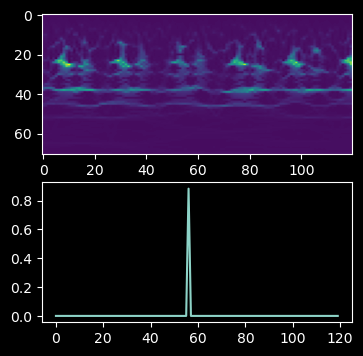

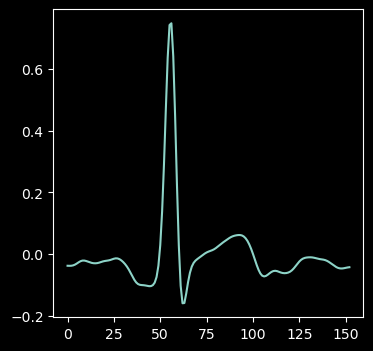

In [8]:
# check the alignment of sst and anchor mask
temp_id = 40
sst_seg=np.load(path_des+f"/obj29_SP_71_/sst_seg_{temp_id}.npy")
anchor_seg=np.load(path_des+f"/obj29_SP_71_/anchor_seg_{temp_id}.npy")
ecg_seg = np.load(path_des+f"/obj29_SP_71_/ecg_seg_{temp_id}.npy")
plt.figure(figsize=(4, 4))
plt.subplot(2, 1, 1)
sst = sst_seg[44,:,:]
plt.imshow(sst, aspect='auto')
plt.subplot(2, 1, 2)
plt.plot((down_sample(anchor_seg,120)))
# plt.plot(((anchor_mask_)))
plt.figure(figsize=(4, 4))
plt.plot(ecg_seg)

0.0

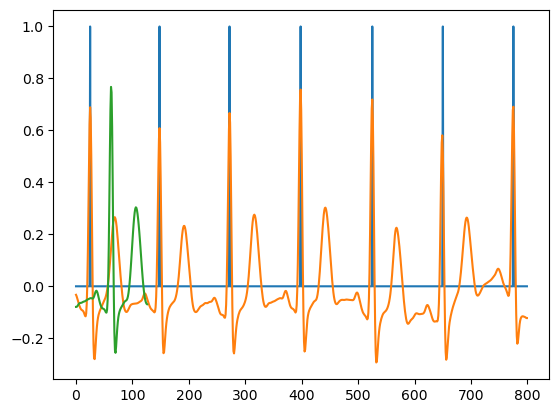

In [25]:
# check the alignment of ECG and anchor mask
plt.plot(normal_ecg(anchor_mask))
plt.plot((anchor_mask_))
plt.plot(ecg_seg)
plt.style.use('default')
anchor_mask[100]

In [17]:
anchor_mask_[np.where(anchor_mask==1)]

array([ 0.27555332,  0.58788799,  0.62749296,  0.16341996, -0.14190216,
       -0.21177162,  0.05327732])